In [1]:
import pandas as pd
import numpy as np
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# for training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error

# for optimize
from skopt import gp_minimize, Optimizer
from skopt.space import Space, Integer, Real

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# custom packages
from bayes_opt import custom_minimize, resume_optimize
from agent import AgentBase

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%load_ext autoreload
%autoreload 2


In [2]:
# meta config
random_seed = 2022

In [3]:
data = pd.read_csv("./data/boston_housing.csv")
data.head(5)
X = data.drop(columns=['medv'])
y = data['medv'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=random_seed)

# fix the first 8 params
clf = LinearRegression()
clf.fit(X_train, y_train)
fixed_params =clf.coef_[:9]

def model(params):
    params = np.concatenate([fixed_params, params])
    y_pred = X_train @ params
    return mean_squared_error(y_train, y_pred)

# tune the rest 5 params
space = [[-20, 20] for _ in range(4)]
x0 = [1 for _ in range(4)]

In [4]:
n_calls = 60
n_random_starts = 20

In [5]:
res_default = gp_minimize(model,        # the function to minimize
                    space,      # the bounds on each dimension of x
                    initial_point_generator="grid",
                    x0=x0,
                    acq_func="EI",      # the acquisition function
                    n_calls=n_calls,         # the number of evaluations of f
                    n_random_starts=n_random_starts,  # the number of random initialization points
                    noise="gaussian",       # the noise level (optional)
                    n_jobs=-1,
                    random_state=random_seed
                )   # the random seed

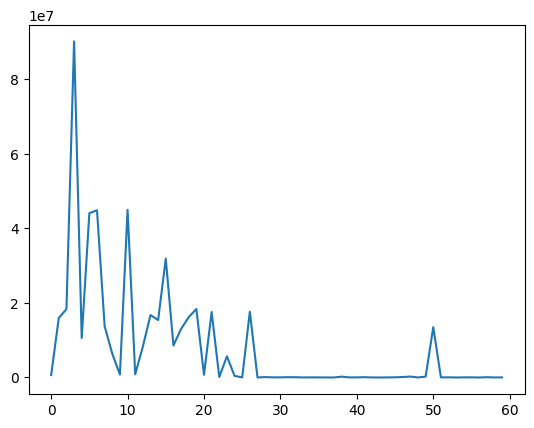

In [6]:
plt.plot(res_default.func_vals)

In [7]:
res_default

          fun: 3815.350010775237
            x: [0, -3, 0, 0]
    func_vals: [ 6.376e+05  1.596e+07 ...  1.318e+04  2.826e+04]
      x_iters: [[1, 1, 1, 1], [-12, -12, 4, 12], [12, 12, -4, 12], [12, 4, 12, 12], [4, 12, 4, -4], [12, 12, 4, -4], [12, 4, 4, 12], [-12, 12, 4, 4], [12, -12, -12, -12], [4, -4, -4, 4], [-12, -4, -4, -12], [4, -4, -4, 12], [4, 12, -12, 4], [-12, -12, 4, 4], [12, -4, -4, 4], [-4, 12, -12, 12], [-4, 12, -4, -4], [12, -12, -4, -12], [12, -4, -4, 12], [-12, -12, 4, -12], [-4, 12, 4, -4], [-20, 20, 20, 20], [-2, 20, 1, 20], [-10, 20, 12, 20], [2, -20, -2, -20], [0, 20, 0, -18], [20, -20, -20, -20], [0, 5, 0, 0], [1, 7, 0, -19], [1, 4, -1, -10], [-1, 3, 0, 19], [0, -16, 1, 17], [0, 10, -1, -5], [0, -13, 1, -10], [-1, -4, 1, 10], [0, -15, 0, 19], [0, -12, 0, 15], [0, -3, 0, 0], [-2, -20, 3, 19], [0, -8, 1, -17], [0, 11, 0, -2], [-1, 5, 0, 5], [0, 14, 0, -13], [0, 2, 0, -7], [0, -7, 0, -1], [0, 1, 0, -17], [1, 17, -2, 11], [-1, 14, 2, -17], [0, 11, 0, -13], [2, 18, -3

In [29]:
agent_a = AgentBase(dim=[0,1], random_seed=random_seed)
agent_b = AgentBase(dim=[2,3], random_seed=random_seed)

In [30]:
res, optimizer = agent_a.initialize_model(
                            model,
                            space,
                            x0,
                            initial_point_generator="grid",
                            acq_func="EI",      # the acquisition function
                            n_random_starts=n_random_starts,         # the number of evaluations of f
                        )

In [31]:
# params
records_star = res.func_vals
rounds = 10
budget_a = budget_b = (n_calls - n_random_starts) // rounds // 2
res_resume_b = res
res_resume_a = res

ys_a = []
ys_b = []
res_resume_a_next = res_resume_a
res_resume_b_next = res_resume_b

agent_a.punish_count = 0
agent_b.punish_count = 0

r_star_est = 1000
r_f_est = 0

for r in range(rounds):
    # Agent A iterates
    if not agent_a.need_punish:
        other_dim = agent_b.dim
        other_val = np.array(res_resume_b.x)[other_dim]

        res_resume_a_next, optimizer, xs_a, ys_a = agent_a.update(
                                            model,
                                            budget_a,
                                            res_resume_b,
                                            optimizer,
                                            other_dim,
                                            other_val
                                            )
    res_resume_b_next = res_resume_a
    ys_b = ys_a

    if agent_a.need_punish:
        res_resume_a_next = res_resume_b
        ys_a = ys_b
        agent_a.punish_count -= 1

    # check whether to punish
    ys_star = min(np.concatenate([ys_a, ys_b]))
    r_star = min(records_star) - min(np.concatenate([ys_a, ys_b, records_star])) - 100.0
    r_star_est = 0.5 * r_star_est + 0.5 * r_star
    r_f = min(records_star) - min(np.concatenate([ys_a, records_star]))
    r_f_est = 0.5 * r_f_est + 0.5 * r_f
    if r_star_est - r_f_est < 0.5:
        print(f"punish at round {r}: ", r_star_est, r_f_est)
        agent_a.punish_count = agent_a.punish(0.75, r_f_est, r_star_est)
        print("punish_count update:", agent_a.punish_count)



    # update params
    res_resume_a = res_resume_a_next
    res_resume_b = res_resume_b_next
    records_star = np.concatenate([records_star, [ys_star]])

punish at round 3:  178839.07779492528 178870.32779492528
punish_count update: 1
punish at round 4:  89369.53889746264 89435.16389746264
punish_count update: 1
punish at round 5:  44634.76944873132 44717.58194873132
punish_count update: 1
punish at round 6:  22267.38472436566 22358.79097436566
punish_count update: 1
punish at round 7:  11083.69236218283 11179.39548718283
punish_count update: 1
punish at round 8:  5491.846181091415 5589.697743591415
punish_count update: 1
punish at round 9:  2695.9230905457075 2794.8488717957075
punish_count update: 1


In [32]:
# params
records_f = res.func_vals
rounds = 10
budget_a = budget_b = (n_calls - n_random_starts) // rounds // 2
res_resume_b = res
res_resume_a = res

ys_a = []
ys_b = []
res_resume_a_next = res_resume_a
res_resume_b_next = res_resume_b

agent_a.punish_count = 0
agent_b.punish_count = 0

for _ in range(rounds):
    # Agent A iterates
    other_dim = agent_b.dim
    other_val = np.array(res_resume_b.x)[other_dim]

    res_resume_a_next, optimizer, xs_a, ys_a = agent_a.update(
                                        model,
                                        budget_a,
                                        res_resume_b,
                                        optimizer,
                                        other_dim,
                                        other_val
                                        )

    # Agent B iterates
    res_resume_b_next = res_resume_a
    ys_b = ys_a
    ys_star = min(np.concatenate([ys_a, ys_b]))

    # update params
    res_resume_a = res_resume_a_next
    res_resume_b = res_resume_b_next
    records_f = np.concatenate([records_f, [ys_star]])

In [33]:
# # params
# records_star = res.func_vals
# rounds = 10
# budget_a = budget_b = (n_calls - n_random_starts) // rounds // 2
# res_resume_b = res
# res_resume_a = res
#
# ys_a = []
# ys_b = []
# res_resume_a_next = res_resume_a
# res_resume_b_next = res_resume_b
#
# agent_a.punish_count = 0
# agent_b.punish_count = 0
#
# for _ in range(rounds):
#     # Agent A iterates
#     other_dim = agent_b.dim
#     other_val = np.array(res_resume_b.x)[other_dim]
#
#     res_resume_a_next, optimizer, xs_a, ys_a = agent_a.update(
#                                         model,
#                                         budget_a,
#                                         res_resume_b,
#                                         optimizer,
#                                         other_dim,
#                                         other_val
#                                         )
#
#     # Agent B iterates
#     other_dim = agent_a.dim
#     other_val = np.array(res_resume_a.x)[other_dim]
#
#     res_resume_b_next, optimizer, xs_b, ys_b = agent_b.update(
#                                         model,
#                                         budget_b,
#                                         res_resume_a,
#                                         optimizer,
#                                         other_dim,
#                                         other_val
#                                         )
#     ys_star = min(np.concatenate([ys_a, ys_b]))
#
#     # update params
#     res_resume_a = res_resume_a_next
#     res_resume_b = res_resume_b_next
#     records_star = np.concatenate([records_star, [ys_star]])

In [34]:
best_f = np.array([min(records_f[:i]) for i in range(1,len(records_f))])
best_star = np.array([min(records_star[:i]) for i in range(1,len(records_star))])

Text(0, 0.5, 'Log Objective Value')

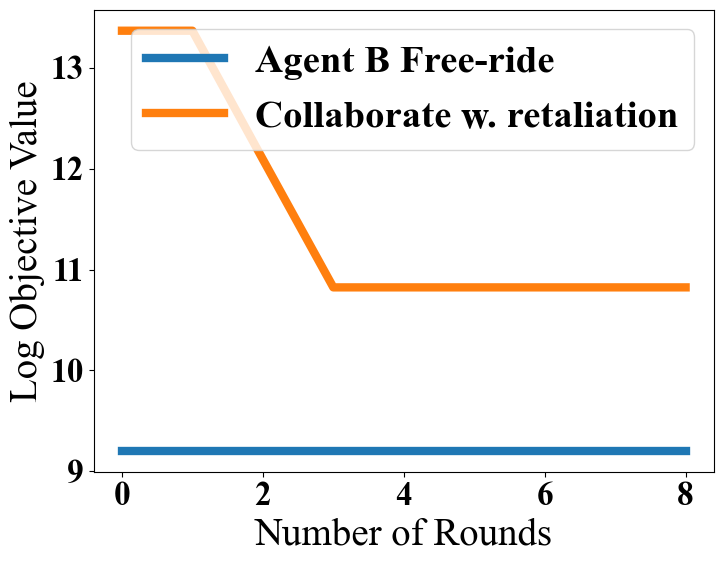

In [35]:
from plot_utils import set_up_plotting
set_up_plotting()

# compare the two approaches
plt.figure(figsize=(8, 6))
plt.plot(np.log(best_f[n_random_starts:]), label="Agent B Free-ride")
plt.plot(np.log(best_star[n_random_starts:]), label="Collaborate w. retaliation")
plt.legend(fontsize=28)
plt.xlabel("Number of Rounds", fontsize=28)
plt.ylabel("Log Objective Value", fontsize=28)

# plt.savefig("./figs/boston_housing_retaliate.pdf", dpi=300, bbox_inches="tight", format="pdf")